In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as nps
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
with zipfile.ZipFile('train.zip', 'r') as z :
    z.extractall('train')

In [3]:
filenames = os.listdir("./train")
categories = []
for image in filenames :
    category = image.split('.')[0]
    if category == 'dog' :
        categories.append(1)
    else :    
        categories.append(0)

In [4]:
df = pd.DataFrame({'filename' : filenames, 'category' : categories})
df.head()

,filename,category
0,__MACOSX,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df['category'].value_counts()

0    1201
1    1201
Name: category, dtype: int64

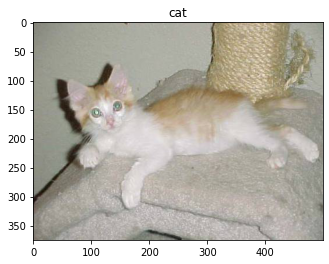

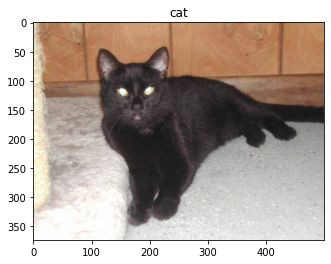

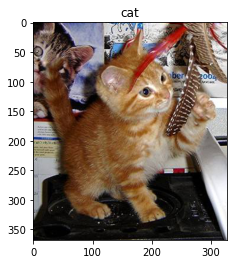

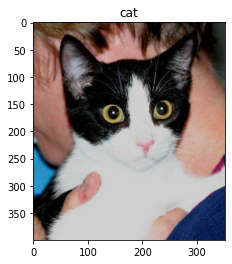

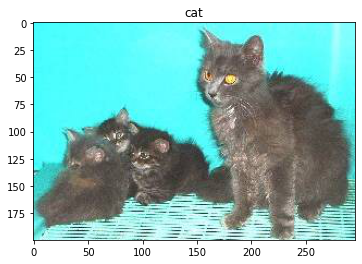

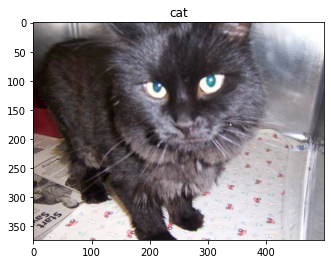

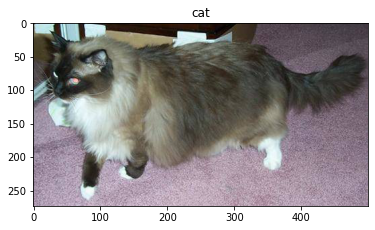

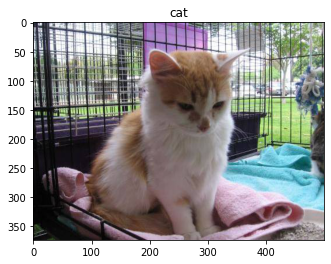

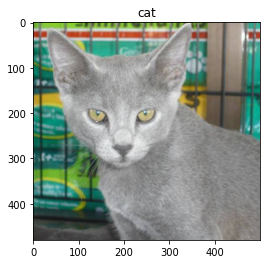

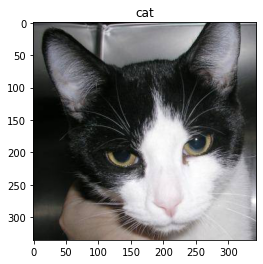

In [6]:
for i in range(10) :
    sample = filenames[i+10]
    image = tf.keras.preprocessing.image.load_img('./train/' + sample)
    plt.imshow(image)
    plt.title('dog' if categories[i+10]==1 else 'cat')
    plt.show()

In [7]:
#model 
model = keras.models.Sequential()

##  Conv_1
model.add(keras.layers.Conv2D(32, 3,input_shape = [128, 128, 3], activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Flatten
model.add(keras.layers.Flatten())

## fc_1
model.add(keras.layers.Dense(1024, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))

## fc_2
model.add(keras.layers.Dense(2, activation = 'sigmoid'))

## optimizer and loss
#optimizer = keras.optimizers.RMSprop(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

2021-12-16 16:57:12.317484: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

In [8]:
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [9]:
df['category'] = df['category'].map({0 : 'cat', 1 : 'dog'})

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [11]:
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
batch_size = 10

In [12]:
train_data = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                         rescale = 1./255,
                                                         horizontal_flip=True)
train_generator = train_data.flow_from_dataframe(train_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)

Found 1920 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [13]:
valid_data = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
                                                         
                                                         
valid_generator = valid_data.flow_from_dataframe(valid_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)

Found 481 validated image filenames belonging to 2 classes.


In [16]:
epochs = 2
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=total_valid//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
192/192 [==============================] - 529s 3s/step - loss: 0.8926 - accuracy: 0.5734 - val_loss: 0.7108 - val_accuracy: 0.5188
Epoch 2/2
192/192 [==============================] - 492s 3s/step - loss: 0.7857 - accuracy: 0.5708 - val_loss: 0.6744 - val_accuracy: 0.5667


In [17]:
model.save_weights("model.h5")

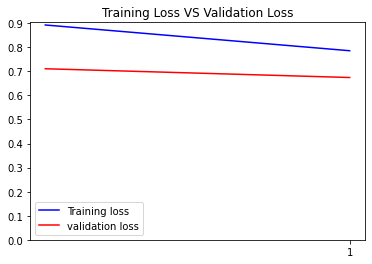

In [18]:
import numpy as np
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

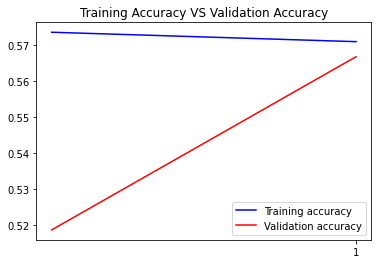

In [19]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()
plt.show()

In [20]:
with zipfile.ZipFile('test.zip', 'r') as z :
    z.extractall('test')

In [21]:
filenames = os.listdir("./test/test1")
test_df = pd.DataFrame({'filename' : filenames})    
samples = test_df.shape[0]

In [24]:
test_data = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_data.flow_from_dataframe(
    test_df, 
    "./test/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=[128,128],
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


In [25]:
predict = model.predict_generator(test_generator, steps=np.ceil(samples/batch_size))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [26]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df

,filename,category
0,1.jpg,1
1,10.jpg,1
2,100.jpg,1
3,1000.jpg,1
4,10000.jpg,0
...,...,...
12495,9995.jpg,0
12496,9996.jpg,0
12497,9997.jpg,0
12498,9998.jpg,0


In [27]:
test_df['category'] = test_df['category'].replace(to_replace = 0, value ="cat")
test_df['category'] = test_df['category'].replace(to_replace = 1, value ="dog")
test_df

,filename,category
0,1.jpg,dog
1,10.jpg,dog
2,100.jpg,dog
3,1000.jpg,dog
4,10000.jpg,cat
...,...,...
12495,9995.jpg,cat
12496,9996.jpg,cat
12497,9997.jpg,cat
12498,9998.jpg,cat
